# Module 11 Part 3: Optimizing Deep Neural Networks - Avoiding Overfitting through Regularization

This module consists of 3 parts:

- **Part 1** - Vanishing/Exploding Gradient Problem

- **Part 2** - Using Faster Optimizers

- **Part 3** - Avoiding Overfitting through Regularization

Each part is provided in a separate notebook file. It is recommended that you follow the order of the notebooks.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<br>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Module-11-Part-3:-Optimizing-Deep-Neural-Networks---Avoiding-Overfitting-through-Regularization" data-toc-modified-id="Module-11-Part-3:-Optimizing-Deep-Neural-Networks---Avoiding-Overfitting-through-Regularization">Module 11 Part 3: Optimizing Deep Neural Networks - Avoiding Overfitting through Regularization</a></span>
</li>
<li><span><a href="#Table-of-Contents" data-toc-modified-id="Table-of-Contents">Table of Contents</a></span>
</li>
<li><span><a href="#Avoiding-Overfitting-through-Regularization" data-toc-modified-id="Avoiding-Overfitting-through-Regularization">Avoiding Overfitting through Regularization</a></span>
<ul class="toc-item">
<li><span><a href="#Early-Stopping" data-toc-modified-id="Early-Stopping">Early Stopping</a></span>
</li>
<li><span><a href="#L1-and-L2-Regularization" data-toc-modified-id="L1-and-L2-Regularization">L1 and L2 Regularization</a></span>
</li>
<li><span><a href="#Dropout" data-toc-modified-id="Dropout">Dropout</a></span>
</li>
<li><span><a href="#Other-Regularization-Techniques" data-toc-modified-id="Other-Regularization-Techniques">Other Regularization Techniques</a></span>
</li>
</ul>
</li>
<li><span><a href="#References" data-toc-modified-id="References">References</a></span>
</li>
</ul>
</div>

# Avoiding Overfitting through Regularization

We will now cover a few popular regularization techniques for large neural networks.

After completing the first two parts of this module, you should have a pretty solid handle on how to properly train a very deep neural network using some of the more sophisticated optimization algorithms available today. However, just because we can get a model to train fast, doesn't mean that the model is going to make accurate predictions. Since neural networks are very complex and have so many parameters, they are highly prone to overfitting. In this section we are going to go over the most popular and effective techniques for dealing with overfitting, namely:

- Early stopping
- L1 and L2 regularization 
- Dropout
- Max-norm regularization
- Data augmentation

After you finish this module, you will have all the basic tools needed to train deep and complex feedforward neural network models.

## Early Stopping

A challenge we are often faced with when training neural networks is in the choice of the number of training epochs to use. Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

Keras supports the early stopping of training via a callback called `EarlyStopping`. This callback allows you to specify the performance measure to monitor and the trigger that will stop the training process. Let's take a quick look at the initialization (init) signature:

```python
from tensorflow.keras.callbacks import EarlyStopping
EarlyStopping(monitor='val_loss', 
              min_delta=0, 
              patience=0, 
              verbose=0, 
              mode='auto', 
              baseline=None, 
              restore_best_weights=False)
```

Let's look into these arguments:

- **`monitor`**: Select the metric or quantity to be monitored.
- **`min_delta`**: Minimum change in the monitored quantity to qualify as an improvement (i.e. an absolute change of less than `min_delta` will count as no improvement).
- **`patience`**: Number of epochs with no improvement after which training will be stopped.
- **`verbose`**: Verbosity mode. To discover the training epoch on which training was stopped, set this argument to 1.
- **`mode`**: One of `{"auto", "min", "max"}`. In `min` mode, training will stop when the quantity monitored has stopped decreasing; in `max` mode, it will stop when the quantity monitored has stopped increasing; in `auto` mode, the direction is automatically inferred from the name of the monitored quantity.
- **`baseline`**: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
- **`restore_best_weights`**: Whether to restore model weights from the epoch with the best value of the monitored quantity. If `False`, the model weights obtained at the last step of training are used.

Most of these arguments are self-explanatory, so lets try incorporating `EarlyStopping` into a model. We will use the `make_moons` dataset with extra noise and only 100 samples so it is easy to overfit (for demonstration purposes). Take a look at the data below.

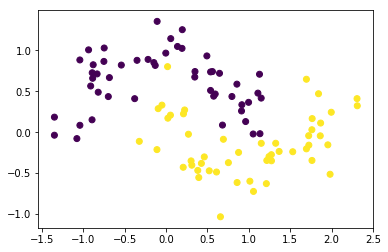

X_train: (50, 2)
y_train: (50,)
X_test: (50, 2)
y_test: (50,)


In [5]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# split into train and test
n_train = 50
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

# Check shapes
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

In [0]:
# Import tf and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Train: 1.000, Test: 0.940


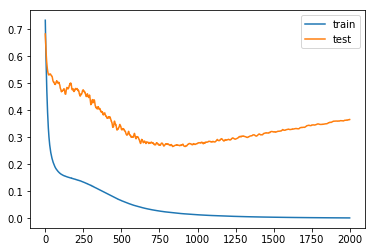

CPU times: user 16.6 s, sys: 894 ms, total: 17.5 s
Wall time: 14.2 s


In [7]:
%%time 
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

We can see that  our model reaches a global minimum on test loss at around 600 epochs, after which it begins to overfit the test data. Let's implement early stopping and run this again. We will monitor the `val_loss` with a `patience` value of 200 epochs, and set `restore_best_weights` to `True`.

In [0]:
# Import EarlyStopping function
from tensorflow.keras.callbacks import EarlyStopping

Restoring model weights from the end of the best epoch.
Epoch 00822: early stopping
Train: 1.000, Test: 0.920


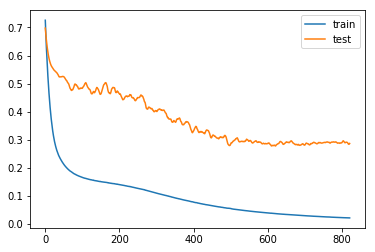

CPU times: user 7.24 s, sys: 457 ms, total: 7.7 s
Wall time: 6.17 s


In [9]:
%%time 
# Note this code block should take around 1 minute to run

# Reset the model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=200, restore_best_weights=True, verbose=1)

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, callbacks=[es], verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Since we had the `restore_best_weights` argument in our callback set to `True`, our model automatically reverts to the best performing weights. That said, if you are training your model for many hours and want to automatically save the best model when a global minimum is reached, you can do so by adding a `ModelCheckpoint` callback into the fit function:

```python
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
```

The code is very simple (and similar to the `EarlyStopping` callback), so we won't cover it here. However, feel free to apply it to your own models, especially if you are planning on training a very large model for many hours.

## L1 and L2 Regularization

Although early stopping works very well in practice, you can usually get much higher performance out of your network by combining it with other regularization techniques. The most common of these techniques is **L1/L2 regularization.** We have covered L1 and L2 regularization in an early part of the course, so we won't go over the theory here. The main difference when applying regularization to neural nets (as opposed to a simple linear regression, for example) is that you apply L1 and L2 to each layer individually.

The `tf.keras.regularizers` module and the `activity_regularizer` argument in most `tf.keras.layer` classes makes applying regularization to individual layers very easy. `tf.keras.regularizers` supports three different regularization techniques, each provided as a class:

- **`l1`**: Activity is calculated as the sum of absolute values.


- **`l2`**: Activity is calculated as the sum of squared values.


- **`l1_l2`**: Activity is calculated as the sum of absolute and squared values.

Each of the `l1` and `l2` regularizers takes a single hyperparameter that controls the amount that each activity contributes to the sum. The `l1_l2` regularizer takes two hyperparameters, one for each of the L1 and L2 methods: 

```python
'''Import regularizers'''
from tensorflow.keras.regularizers import l1, l2, l1_l2
'''Instantiate regularizers'''
reg_l1 = l1(0.001)
reg_l2 = l1(0.001)
reg_l1l2 = l1_l2(0.001, 0.001)
```

To add the above regularizers to your models, you have two options:

1) Apply regularization PRE activation:

```python
...
model.add(Dense(32, activation=None, activity_regularizer=l1(0.001)))
model.add(Activation('relu')
...
```

2) Apply regularization POST activation:

```python
...
model.add(Dense(32, activation='relu', activity_regularizer=l1(0.001)))
...
```

PRE activation is probably the preferred usage of activation regularization for the model to learn to take activations to a true zero value in conjunction with the rectified linear activation function. Nevertheless, you should test out both methods to see which one works best with your model architecture and dataset.

Let's test out these regularizers on the `make_circles` dataset below. Just as we did in the `EarlyStopping` example, we will use a small sample size (100 observations with a 30/70 split) so that the model is likely to overfit the data. 

Hopefully our L1/L2 regularizers will step in to help.

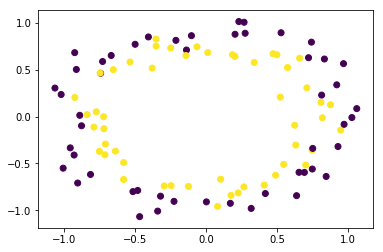

X_train: (30, 2)
y_train: (30,)
X_test: (70, 2)
y_test: (70,)


In [10]:
from sklearn.datasets import make_circles

# Generate 2d classification dataset
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# split into train and test
n_train = 30
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

# Check shapes
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

Train: 1.000, Test: 0.771


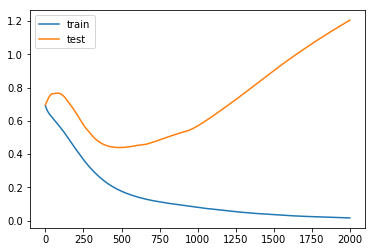

CPU times: user 15.1 s, sys: 729 ms, total: 15.8 s
Wall time: 13 s


In [11]:
%%time 
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Once again, we can see the model is overfitting the training data. Lets add regularization and see if it makes a difference. We will use `l1_l2` below, but as always you are encouraged to try out multiple approaches to find one that best fits your data and objectives. 

In [0]:
# Import regularizers and activation layer
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Activation

Train: 0.967, Test: 0.771


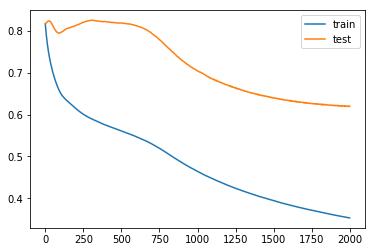

CPU times: user 15.7 s, sys: 769 ms, total: 16.4 s
Wall time: 14 s


In [13]:
%%time 
# Note this code block should take around 1 minute to run

reg_l1l2 = l1_l2(0.005, 0.005)

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation=None, activity_regularizer=reg_l1l2))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Not bad! The `l1_l2` regularization seems to prevent the model from overfitting, and the test accuracy values seem to level off at about epoch 1000. Again, we decided to use `l1_l2` regularization, but every model and dataset is different so it is up to you to experiment and find the right combination for your use case.

## Dropout

The most popular regularization technique for deep learning is arguably **dropout**, a method proposed by Geoffrey Hinton in 2012 and further detailed in a paper by Nitish Srivastava in 2014. The technique has proven to improve accuracy for a wide variety of model architectures &mdash; even state-of-the-art neural networks often get a 1–2% accuracy boost simply by adding dropout. The algorithm itself is surprisingly simple:

- At every training step, every neuron (including the input neurons but excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be ignored during this training step, but it may be active during the next step.


- The hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, neurons do NOT get dropped anymore.

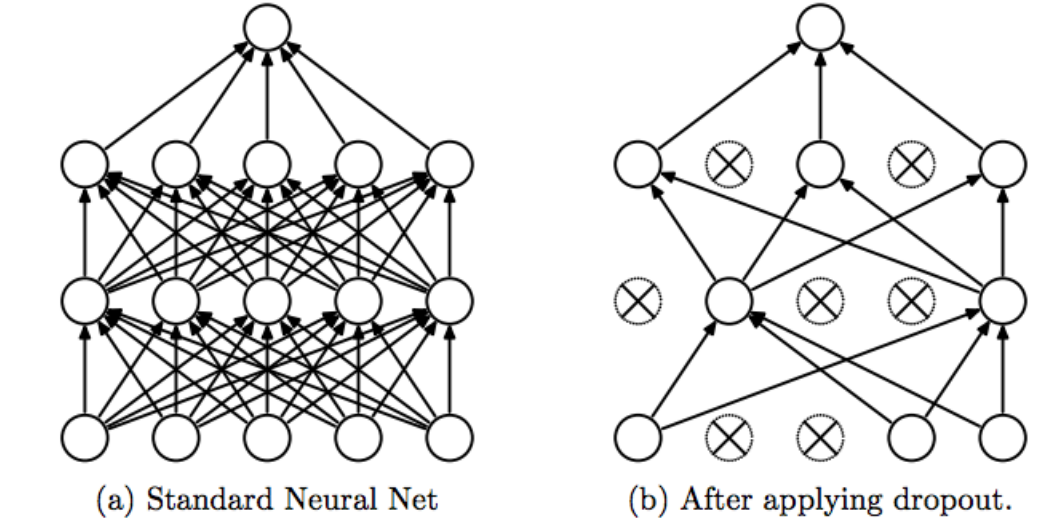

<br><center><i>A basic representation of dropout regularization as applied to a standard feedforward neural network. </i><b>Source</b>: University of Waterloo</center>

The essential intuition here is that neurons trained with dropout cannot co-adapt with their neighboring neurons &mdash; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons. They must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs and in the end you get a more robust network that generalizes better.

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there is a total of $2^N$ possible networks (where $N$ is the total number of droppable neurons). This means that it is extremely unlikely that the same neural network will be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance). These neural networks are obviously not independent as they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.

**NOTE:** There is one small but important technical detail:

- Suppose the dropout rate $p = 50$. This means during testing, a neuron will be connected to twice as many input neurons as it was (on average) during training (all neurons are used during testing).


- To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on and it is unlikely to perform well. 


- The general rule is: **multiply each input connection weight by the keep probability $(1-p)$ after training**.

We can implement dropout for each individual layer in Keras using a `tf.keras.layers.Dropout` layer as follows:

```python
'''Example of dropout between fully connected layers'''
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
...
model.add(Dropout(rate=0.8, input_shape=(784,)))
model.add(Dense(32))
model.add(Dropout(rate=0.5))
model.add(Dense(1))
```

Note that we add a `Dropout` layer just as we would add another `Dense` or `Activation` layer, and we use the `rate` argument to specify the "keep probability" (the probability a neuron will remain on). We also apply a 20% dropout rate (80% keep probability) to the input layer, by specifying `input_shape` in the first dropout layer.

Let's test out dropout. Here we will use the 3 dimensional `make_s_curve` dataset.

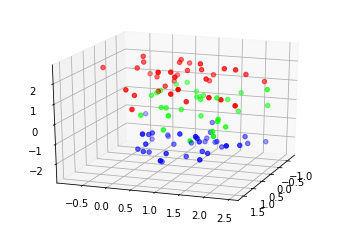

X_train: (30, 3)
y_train: (30, 3)
X_test: (70, 3)
y_test: (70, 3)


In [14]:
from sklearn.datasets import make_s_curve
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd

# Generate 2d classification dataset
X, y = make_s_curve(100, noise=0.3, random_state=1)
# Transform data to multi-class
y = pd.cut(y, bins=3, labels=[0,1,2])
y = to_categorical(y)

ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y, cmap='Greens');
ax.view_init(20,20)
plt.show()

# split into train and test
n_train = 30
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

# Check shapes
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

Train: 1.000, Test: 0.829


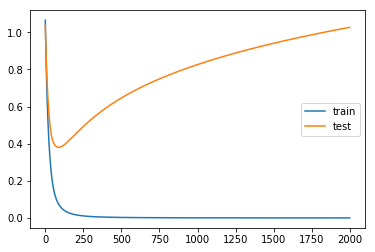

CPU times: user 14.9 s, sys: 715 ms, total: 15.6 s
Wall time: 13 s


In [15]:
%%time 
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dense(500, input_dim=3, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# Import dropout
from tensorflow.keras.layers import Dropout

W0719 00:54:43.171049 140274711414656 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train: 0.867, Test: 0.743


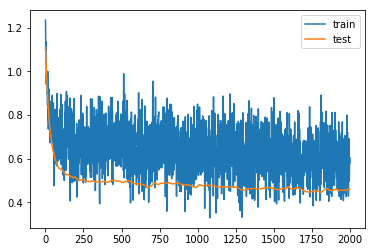

CPU times: user 16.9 s, sys: 801 ms, total: 17.7 s
Wall time: 14.4 s


In [17]:
%%time 
# Note this code block should take around 1 minute to run

# define model
model = Sequential()
model.add(Dropout(rate=0.5)) # Dropout input neurons
model.add(Dense(500, input_dim=3, activation='relu'))
model.add(Dropout(rate=0.8)) # Dropout hidden neurons
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

As we can see, dropout seems to prevent the model from overfitting. The volatility in the training accuracy is due to the fact that we are effectively running a different model on each iteration.

## Other Regularization Techniques

So far in this section of the module, we have learned about the early stopping, L1/L2, and dropout regularization techniques. In most cases, these will be sufficient for training your deep neural network models. However there are a couple of other techniques that you should be aware of: **max-norm regularization** and **data augmentation**. 

- **Max-norm regularization:**<br><br>

    - This technique constrains the weight sizes of the incoming connections in each layer such that $\left\|w\right\| ≤ r$, where $r$ is the max-norm hyperparameter and $\left\|w\right\|$ is the L2 norm of the weight parameters. Reducing $r$ increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the vanishing/exploding gradient problems (particularly if you are using batch normalization).<br><br>
    
    - You can implement max-norm fairly easily with Keras using the `tensorflow.keras.constraints.MaxNorm` function. The code may look something like this:
    
```python
from tensorflow.keras.constraints import MaxNorm
...
mn = MaxNorm(max_value=3)
model.add(Dense(32, activation='relu', kernel_constraint=mn))
...
```

- **Data augmentation:**<br><br>

    - Data augmentation consists of generating new training instances from existing ones &mdash; artificially boosting the size of your training set. This technique (if done properly) will likely help reduce overfitting. This is particularly common for audio and image classification problems. The trick here is to generate realistic training instances. Ideally, a human should NOT be able to tell generated images apart from original images. For instance, adding Gaussian white noise to expand a dataset is very common practice. Keras actually has a ```GaussianNoise``` layer so that you can easily incorporate this method into your existing models. Check out the documentation here: https://keras.io/layers/noise/#gaussiannoise.<br><br>
    
    - For image classification problems (or really almost any machine vision problem), you can also try slightly shifting, rotating, and resizing every picture in the training set by various amounts and adding the resulting pictures to the training set. This forces the model to be more tolerant to the position, orientation, and size of the objects in the picture you are trying to classify. By combining these transformations you can greatly increase the size of your training set. The Keras ```ImageDataGenerator``` is built specifically for these sorts of image preprocessing tasks. You can find the documentation on the Keras website here: https://keras.io/preprocessing/image/.

**Conclusion & Next Steps**

You now know how to construct and train feedforward neural networks for regression and classification, and you are well equipped to begin exploring some of the more complex concepts and architectures in deep learning.

Moving forward, beyond this course, you may want to explore sequence modeling with **recurrent neural networks**, or image classification with **convolutional neural networks**. There is lots more to learn, but you have a built a solid foundation and can tackle any of these topics with confidence.

**End of Module**

You have reached the end of this module.

If you have any questions, please reach out to your peers using the discussion boards. If you
and your peers are unable to come to a suitable conclusion, do not hesitate to reach out to
your instructor on the designated discussion board.

# References

- Géron, A. (2019). Chapter 11: Training Deep Neural Nets in *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2nd ed.). O’Reilly Media. https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/


- TensorFlow documentation and tutorials: https://www.tensorflow.org/tutorials


- Keras documentation and tutorials: https://keras.io/